# Spectral simulations with gammapy

## Studying systematic effects on spectral parameters

### Objective

**Quantify the systematic errors on spectral parameters caused by a possible absolute energy scale bias using simulations.**

### Steps

* Create a fake observation of the Crab using CTA alpha configuration and build a 1D spectrum dataset for this observation
* Fake multiple times a log-parabola source spectrum with ON-OFF statistic and fit it and to measure the statistcal uncertainty expected
* Build a custom spectral model to take into account possible systematic bias in absolute energy scale
* Perform simulations of the observation taking into account the systematic effect of the energy scale bias on the fitted spectral parameters. Measure the systematic uncertainty introduced.
* Perform the same thing for an uncertainty of the alpha parameter 

In [1]:
import numpy as np
import logging
from astropy.coordinates import SkyCoord
from astropy.table import Table
import astropy.units as u
from gammapy.data import Observation, observatory_locations, FixedPointingInfo, PointingMode
from gammapy.irf import load_irf_dict_from_file
from gammapy.maps import MapAxis, Map, RegionGeom
from gammapy.datasets import SpectrumDataset, Datasets, SpectrumDatasetOnOff
from gammapy.makers import SpectrumDatasetMaker, SafeMaskMaker
from gammapy.modeling import Fit
from gammapy.modeling.models import SkyModel, LogParabolaSpectralModel
import matplotlib.pyplot as plt 

In [2]:
logging.basicConfig()    
log = logging.getLogger("Simulation")
log.setLevel(logging.INFO) #INFO, WARNING, DEBUG

In [3]:
irfs = load_irf_dict_from_file("$GAMMAPY_DATA/cta-caldb/Prod5-South-20deg-AverageAz-14MSTs37SSTs.180000s-v0.1.fits.gz")

#### Define pointing positions

Here we use a wobble position around the Crab.

In [4]:
target = SkyCoord(83.6333, 22.0133, unit="deg", frame="icrs")

pointing_position = target.directional_offset_by(90*u.deg, 1*u.deg)
pointing = FixedPointingInfo(
    mode=PointingMode.POINTING,
    fixed_icrs=pointing_position.icrs,
)
print(pointing)

FixedPointingInfo:

mode:        PointingMode.POINTING
coordinates: <SkyCoord (ICRS): (ra, dec) in deg
    (84.71191803, 22.00977198)>


We assume a 3 hours long observation (for simplicity we don't create a list of shorter runs).

In [5]:
livetime = 3 * u.h
location = observatory_locations["cta_south"]

obs = Observation.create(
            pointing=pointing, 
            obs_id=1,
            location=location, 
            livetime=livetime, 
            irfs=irfs
        )

In [6]:
print(obs)

Observation

	obs id            : 1 
 	tstart            : 51544.00
	tstop             : 51544.12
	duration          : 10800.00 s
	pointing (icrs)   : 84.7 deg, 22.0 deg

	deadtime fraction : 0.0%



### Defining the reduced dataset geometry

We prepare the 1D spectra geometry. We need to provide the binning in reco and true energy, for the counts, counts_off and the IRFs.

We take a region of 0.1 degree around the Crab nebula

In [7]:
energy = MapAxis.from_energy_bounds(0.05, 100, 5, unit='TeV', per_decade=True)
energy_true = MapAxis.from_energy_bounds(0.025, 200, 10, unit='TeV', per_decade=True, name="energy_true")

geom = RegionGeom.create("icrs;circle(83.633, 22.014, 0.1)", axes=[energy])

In [8]:
reference_dataset = SpectrumDataset.create(geom, energy_axis_true=energy_true)

#### Instantiate the data reduction Makers
- SpectrumDatasetMaker projects the events and IRF in the correct geometry. Here we require that PSF leakage is to be corrected.
- We don't create a background maker since there is no counts information to rely on here. We are just interested in getting the expected background in the ON region.
- The SafeMaskMaker will create a boolean mask stored on the Dataset to deal with the safe energy range. Here we impose that the energy bias be less than 10%. 


In [9]:
maker = SpectrumDatasetMaker(["background", "edisp", "exposure"], containment_correction=True)
safe_mask_maker = SafeMaskMaker(methods=["edisp-bias"], bias_percent=10)

### Data reduction 
Now we can perform the data reduction to create the reference `Dataset`. 

In [10]:
reference_dataset = maker.run(reference_dataset, obs)
reference_dataset = safe_mask_maker.run(reference_dataset, obs)

As expected the reference dataset contains only the number of expected background counts but no signal.

/home/khelifi/mambaforge/envs/gammapy-1.1/lib/python3.9/site-packages/gammapy/maps/region/ndmap.py:169: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale("log")


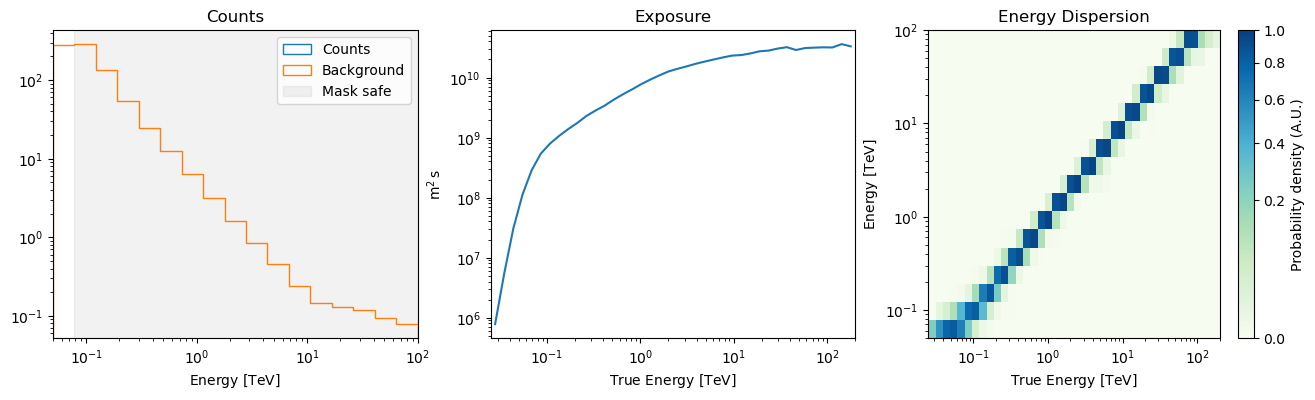

In [11]:
reference_dataset.peek();

## Simulate datasets

### Model definition

Source models in gammapy are `SkyModel`. They are usually the combination of a `SpectralModel`, a `SpatialModel` and possibly a `TemporalModel`.

Here we only need a `SpectralModel`. It is the only mandatory component.

In [12]:
spectral_model = LogParabolaSpectralModel(
        alpha=2.5,
        beta=0.25, 
        amplitude="3.8e-11 cm-2s-1TeV-1",
        reference="1 TeV",
    )

model = SkyModel(
    spectral_model=spectral_model,
    name="crab"
)

In [13]:
reference_dataset.models = [model]

### Create ON-OFF datasets

Since background maker was applied the datasets are regular datasets: i.e. they contain a background model but no acceptance ON and OFF nor OFF counts. 

We have therefore to convert them to the proper format adding the required information. The OFF counts will be simulted later.

#### Create acceptance vectors

we assume energy independent alpha_onoff=1/10: 

In [14]:
acceptance = Map.from_geom(geom, data=1, unit="")
acceptance_off = Map.from_geom(geom, data=10, unit="")

#### Fake counts

Here we create the ON-OFF datasets and fake their content.

We perform a large number of simulations to explore the disctribution of fitted parameters.

In [15]:
%%time
n_sim = 1000
# n_sim = 10
simulated_datasets = []

for i in range(n_sim):
    dataset_on_off = SpectrumDatasetOnOff.from_spectrum_dataset(dataset=reference_dataset, 
                                                      acceptance=acceptance,
                                                      acceptance_off=acceptance_off
                                                     )
    dataset_on_off.fake(npred_background=reference_dataset.background)
    simulated_datasets.append(dataset_on_off)

CPU times: user 9.96 s, sys: 42.2 ms, total: 10 s
Wall time: 10 s


### Perform the fit

Here we fit a log parabola on the data and explore the distribution of parameters

In [16]:
%%time

results = []
fit = Fit()
for dataset in simulated_datasets:
    # We use a copy of the simulated model
    dataset.models = [model.copy()]

    fit_result = fit.run([dataset])

    if fit_result.success:
        par_dict = {}
        for par in fit_result.parameters.free_parameters:
            par_dict[par.name] = par.quantity
        results.append(par_dict)


CPU times: user 2min 24s, sys: 619 ms, total: 2min 24s
Wall time: 2min 24s


We convert the list of dictionnaries into an astropy `Table`.

In [17]:
fitted_params = Table(results).to_pandas()

We compute the statistical errors from the distribution of the MC realizations.

In [18]:
mean = fitted_params.mean()
uncertainty = fitted_params.std()

In [19]:
for name in ['amplitude', 'alpha', 'beta']:
    print(f"{name} :\t {mean[name]:.2e} -+ {uncertainty[name]:.2e}")

amplitude :	 3.80e-11 -+ 5.14e-13
alpha :	 2.50e+00 -+ 1.33e-02
beta :	 2.50e-01 -+ 8.13e-03


#### Looking at the simulation results

We can use the corner package to represent the fitted parameters correlations.

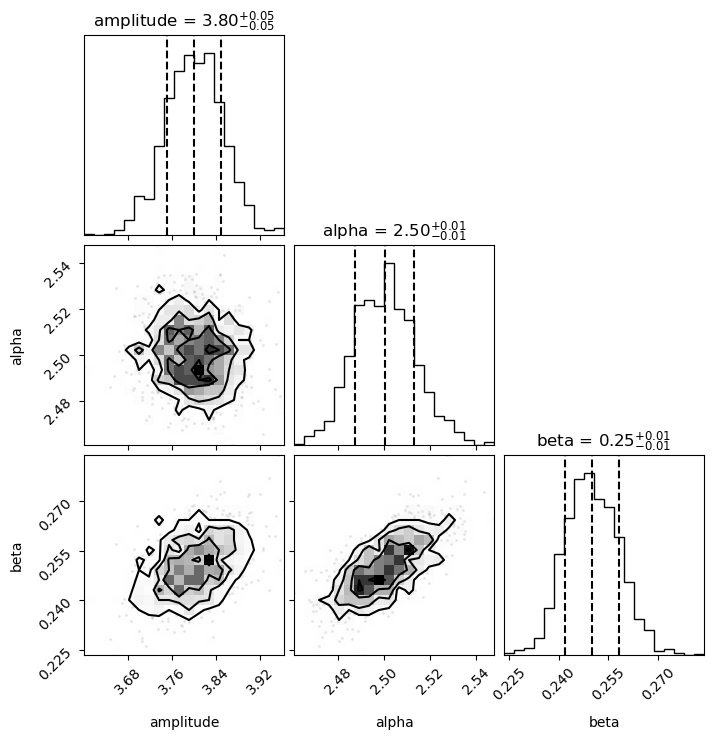

In [20]:
import corner

fitted_params['amplitude'] *= 1e11

figure = corner.corner(fitted_params,quantiles=[0.16, 0.5, 0.84],
              show_titles=True, title_kwargs={"fontsize": 12})

## Exploring systematic effects: energy scale bias

#### Creating a biased log-parabola model

A systematic bias in the energy reconstruction that is not accounted for by the energy dispersion could have a significant impact of the fitted spectral parameters of the Crab nebula.

We propose to explore this idea in the code below.

We first use the possibility offered by gammapy to create a custom model to add a log parabola model with a systematic constant energy bias. This bias will come in addition to the one stored in the `edisp` and quantified by the shower simulations.

In [21]:
from gammapy.modeling import Parameter
from gammapy.modeling.models import SpectralModel, LogParabolaSpectralModel

class BiasedLogParabolaSpectralModel(SpectralModel):
    tag = "BiasedLogParabolaSpectralModel"
    amplitude = Parameter("amplitude", "1e-12 cm-2 s-1 TeV-1", min=0, is_norm=True)
    alpha = Parameter("alpha", 2.5, min=0)
    beta = Parameter("beta", 0.5)
    reference = Parameter("reference", "1 TeV", frozen=True)
    bias = Parameter("bias", 1, min=0)
        
    @staticmethod
    def evaluate(energy, amplitude, alpha, beta, reference, bias):
        energy = bias.value * energy
        logpwl = LogParabolaSpectralModel.evaluate(
            energy=energy,
            alpha=alpha,
            beta=beta,
            amplitude=amplitude,
            reference=reference,
        )
        return logpwl

We can look at the resulting spectra. Obviously the impact on the amplitude is very significant.

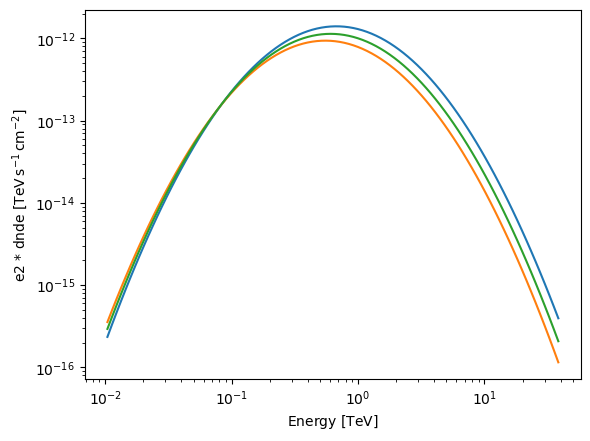

In [22]:
biased_spectral_model = BiasedLogParabolaSpectralModel()
biased_spectral_model.bias.value=0.9
ax = biased_spectral_model.plot([0.01,40]*u.TeV, energy_power=2)
biased_spectral_model.bias.value=1.1
biased_spectral_model.plot([0.01,40]*u.TeV, energy_power=2, ax=ax)
biased_spectral_model.bias.value=1.0
biased_spectral_model.plot([0.01,40]*u.TeV, energy_power=2, ax=ax);

In [23]:
biased_spectral_model = BiasedLogParabolaSpectralModel()

biased_spectral_model.alpha.value = spectral_model.alpha.value
biased_spectral_model.beta.value = spectral_model.beta.value
biased_spectral_model.amplitude.value = spectral_model.amplitude.value

In [24]:
biased_model = SkyModel(spectral_model=biased_spectral_model, name="biased_crab")

#### Fake counts taking bias into account

Here we use the biased model and randomize the bias values. We then create the ON-OFF datasets and fake their content.

We assume a typical uncertainty on the energy scale of 3 percent.

In [25]:
%%time
simulated_biased_datasets = []

for i in range(n_sim):
    dataset_on_off = SpectrumDatasetOnOff.from_spectrum_dataset(dataset=reference_dataset, 
                                                      acceptance=acceptance,
                                                      acceptance_off=acceptance_off
                                                     )
    # Randomize random bias
    biased_model.spectral_model.bias.value = np.random.normal(loc=1.0, scale=0.03)
    # Set the model on the ON-OFF dataset
    dataset_on_off.models = [biased_model]

    dataset_on_off.fake(npred_background=reference_dataset.background)
    simulated_biased_datasets.append(dataset_on_off)

CPU times: user 10.6 s, sys: 19.9 ms, total: 10.6 s
Wall time: 10.6 s


### Perform the fit

Here we fit a log parabola without a bias on the data and explore the distribution of parameters

In [26]:
%%time

results_biased = []
fit = Fit()
for dataset in simulated_biased_datasets:
    # We use a copy of the simulated model
    dataset.models = [model.copy()]

    fit_result = fit.run([dataset])

    if fit_result.success:
        par_dict = {}
        for par in fit_result.parameters.free_parameters:
            par_dict[par.name] = par.quantity
        results_biased.append(par_dict)

CPU times: user 2min 36s, sys: 820 ms, total: 2min 37s
Wall time: 2min 37s


In [27]:
fitted_params_with_energy_bias = Table(results_biased).to_pandas()

In [28]:
total_mean = fitted_params_with_energy_bias.mean()
total_uncertainty = fitted_params_with_energy_bias.std()

In [29]:
for name in ['amplitude', 'alpha', 'beta']:
    print(f"{name} :\t {total_mean[name]:.2e} -+ {total_uncertainty[name]:.2e}")

amplitude :	 3.81e-11 -+ 2.92e-12
alpha :	 2.50e+00 -+ 2.01e-02
beta :	 2.50e-01 -+ 8.42e-03


To separate statistics from systematics we assume the toatl uncertainty is the quadratic sum of statistic and systematic errors.

In [30]:
systematic_uncertainty = np.sqrt(total_uncertainty**2 - uncertainty**2)

In [31]:
for name in ['amplitude', 'alpha', 'beta']:
    print(f"{name} :\t {total_mean[name]:.2e} -+\t"
          f" {uncertainty[name]:.2e} (stat) -+\t"
          f" {systematic_uncertainty[name]:.2e} (sys)")

amplitude :	 3.81e-11 -+	 5.14e-13 (stat) -+	 2.88e-12 (sys)
alpha :	 2.50e+00 -+	 1.33e-02 (stat) -+	 1.50e-02 (sys)
beta :	 2.50e-01 -+	 8.13e-03 (stat) -+	 2.17e-03 (sys)


## Exploring systematic effects: uncertainty of alpha_onoff (ratio of ON/OFF acceptance)

#### Simulated data with an additional bias of alpha_onoff

A systematic bias in the estimation of alpha_onoff can also occur. 
In the following we will assume that the ON acceptance is uncertain by a factor of 5%.

In [32]:
%%time
simulated_biased_datasets = []

for i in range(n_sim):
    dataset_on_off = SpectrumDatasetOnOff.from_spectrum_dataset(dataset=reference_dataset, 
                                                      acceptance=acceptance,
                                                      acceptance_off=acceptance_off
                                                     )
    # Set the model on the ON-OFF dataset
    dataset_on_off.models = [model]
    
    # Add the bias on acceptance for simulation only
    dataset_on_off.acceptance *= np.random.normal(loc=1.0, scale=0.05)

    dataset_on_off.fake(npred_background=reference_dataset.background)

    # We put the unbiased acceptance in the dataset
    dataset_on_off.acceptance = acceptance
    
    simulated_biased_datasets.append(dataset_on_off)

CPU times: user 12.9 s, sys: 51.9 ms, total: 12.9 s
Wall time: 12.9 s


In [33]:
%%time

results_biased = []
fit = Fit()
for dataset in simulated_biased_datasets:
    # We use a copy of the simulated model
    dataset.models = [model.copy()]

    fit_result = fit.run([dataset])

    if fit_result.success:
        par_dict = {}
        for par in fit_result.parameters.free_parameters:
            par_dict[par.name] = par.quantity
        results_biased.append(par_dict)

CPU times: user 2min 31s, sys: 676 ms, total: 2min 32s
Wall time: 2min 32s


In [34]:
fitted_params_with_alpha_bias = Table(results_biased).to_pandas()
total_mean = fitted_params_with_alpha_bias.mean()
total_uncertainty = fitted_params_with_alpha_bias.std()

In [35]:
for name in ['amplitude', 'alpha', 'beta']:
    print(f"{name} :\t {total_mean[name]:.2e} -+ {total_uncertainty[name]:.2e}")

amplitude :	 3.82e-11 -+ 6.64e-13
alpha :	 2.50e+00 -+ 1.64e-02
beta :	 2.61e-01 -+ 2.27e-02


In [36]:
systematic_uncertainty = np.sqrt(total_uncertainty**2 - uncertainty**2)

In [37]:
for name in ['amplitude', 'alpha', 'beta']:
    print(f"{name} :\t {total_mean[name]:.2e} -+\t"
          f" {uncertainty[name]:.2e} (stat) -+\t"
          f" {systematic_uncertainty[name]:.2e} (sys)")

amplitude :	 3.82e-11 -+	 5.14e-13 (stat) -+	 4.20e-13 (sys)
alpha :	 2.50e+00 -+	 1.33e-02 (stat) -+	 9.56e-03 (sys)
beta :	 2.61e-01 -+	 8.13e-03 (stat) -+	 2.12e-02 (sys)


## Going further

- Plot the average fitted spectrum with the butterflies of errors
- Combine the two effects
- Introduce an uncertainty on the effective area by adding an uncertainty on the spectral index and amplitude of the simulated source (e.g. by multplying it by a PowerLawNormSpectralModel)